# Equitable AI for Dermatology

AI is transforming healthcare, yet dermatology AI tools often underperform for people with darker skin tones due to a lack of diverse training data. This gap can lead to diagnostic errors, delayed treatments, and health disparities for underserved communities.

This challenge from Break Through Tech and the Algorithmic Justice League invites you to help address this gap by building an inclusive machine learning model for dermatology.

In [141]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Dropout, Input
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow import data as tf_data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score
from collections import Counter
from sklearn.model_selection import train_test_split
import glob
from tqdm import tqdm
from tensorflow.keras.applications import MobileNet
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder

If you are usin you're using google colab, you'll need to run the following cell to retrieve the data.

In [ ]:
# mount data from drive
from google.colab import drive
drive.mount('/content/drive')
# access the datafile
trainDataSet_filename = os.path.join(os.getcwd(), "drive/MyDrive/BTTAI Kaggle AJL Team13/bttai-ajl-2025", "train.csv")
df = pd.read_csv(trainDataSet_filename)

If you are working locally, you'll need to run the following cell.

In [94]:
# access the datafile
df = pd.read_csv('./bttai-ajl-2025/train.csv')

## Data Profiling and Visualization

### Data Variables
- md5hash (string) is the unique identifier
- fitpatric_scale (int) is a nominal int in range [-1, 0) and [1, 6] indicating self-described (Fitzpatrick Skin Type) FST
- fitzpatrick_centaur (int)	nominal int in the range [-1, 0) and [1, 6] indicating FST assigned by Centaur Labs, a medical data annotation firm
- label (string) is our dependent variable indicating the medical diagnosis. 21 possible values
- nine_paritition_label (string) is a categorical variable indicating one of nine diagnostic categories
- three_paritition_label (string) is a categorical variable indicating one of three diagnostic categories
- qc (int) a nominal int for quality control check by a Board-certified dermatologist.
  - 1: Diagnostic - the image shows an good example of the skin condition
  - 2: Characteristic - the image shows something that could be the skin condition, but isn't diagnostic
  - 3: Wrongly labelled - the image shows something that is definitely not the labeled condition
  - 4: Other
  - 5: Potentially - not clearly diagnostic but not necessarily mislabeled, further testing would be required
- ddi_scale (int) A column used to reconcile this dataset with another dataset (may not be relevant)









In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2860 entries, 0 to 2859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   md5hash                2860 non-null   object
 1   fitzpatrick_scale      2860 non-null   int64 
 2   fitzpatrick_centaur    2860 non-null   int64 
 3   label                  2860 non-null   object
 4   nine_partition_label   2860 non-null   object
 5   three_partition_label  2860 non-null   object
 6   qc                     90 non-null     object
 7   ddi_scale              2860 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 178.9+ KB


In [98]:
# Not super useful because Fitzpatrick variables are nominal variables
df.describe()

,fitzpatrick_scale,fitzpatrick_centaur,ddi_scale
count,2860.000000,2860.000000,2860.000000
mean,2.524476,2.095455,23.547552
std,1.474428,1.510942,15.530522
min,-1.000000,-1.000000,-1.000000
25%,2.000000,1.000000,12.000000
50%,2.000000,2.000000,12.000000
75%,3.000000,3.000000,34.000000
max,6.000000,6.000000,56.000000


In [100]:
# Number of unique values per variable
df.nunique()

md5hash                  2860
fitzpatrick_scale           7
fitzpatrick_centaur         7
label                      21
nine_partition_label        7
three_partition_label       3
qc                          5
ddi_scale                   4
dtype: int64

In [102]:
# Explore label variable
print(df["label"].unique())

['prurigo-nodularis' 'basal-cell-carcinoma-morpheiform' 'keloid'
 'basal-cell-carcinoma' 'seborrheic-keratosis' 'eczema' 'folliculitis'
 'squamous-cell-carcinoma' 'actinic-keratosis' 'mycosis-fungoides'
 'acne-vulgaris' 'dyshidrotic-eczema' 'melanoma' 'epidermal-nevus'
 'malignant-melanoma' 'pyogenic-granuloma' 'dermatofibroma'
 'kaposi-sarcoma' 'acne' 'dermatomyositis'
 'superficial-spreading-melanoma-ssm']


In [104]:
# identify variables with missing values
df.isna().sum()

md5hash                     0
fitzpatrick_scale           0
fitzpatrick_centaur         0
label                       0
nine_partition_label        0
three_partition_label       0
qc                       2770
ddi_scale                   0
dtype: int64

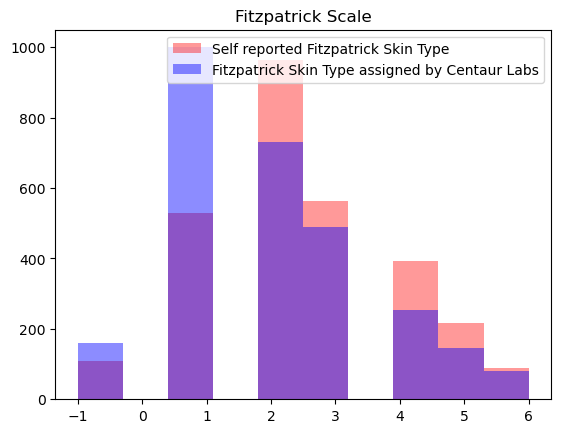

In [106]:
# visualize fitzpatrick scale

plt.hist(df["fitzpatrick_scale"], alpha=0.40, color='red')
plt.hist(df["fitzpatrick_centaur"], alpha=0.45, color='blue')

plt.title("Fitzpatrick Scale")

plt.legend(["Self reported Fitzpatrick Skin Type",
            "Fitzpatrick Skin Type assigned by Centaur Labs"])

plt.show()

In [108]:
df.query("fitzpatrick_scale > 3")

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,ddi_scale
0,fd06d13de341cc75ad679916c5d7e6a6,4,4,prurigo-nodularis,benign-epidermal,benign,NaN,34
2,c94ce27e389f96bda998e7c3fa5c4a2e,5,5,keloid,inflammatory,non-neoplastic,1 Diagnostic,56
7,8adbbbc4e50a0df8b89710dfd495d3c5,5,4,eczema,inflammatory,non-neoplastic,NaN,56
10,29cec54fd4c616bcbc1b0eeb68d8f68b,4,2,actinic-keratosis,malignant-epidermal,malignant,NaN,34
13,f20ccf2ee75f8b3b2f51c4215cd45216,4,3,folliculitis,inflammatory,non-neoplastic,NaN,34
...,...,...,...,...,...,...,...,...
2836,de0b8a88c10b392c990a4109d7483e95,6,5,eczema,inflammatory,non-neoplastic,NaN,56
2837,cb9baa2c3e0255370714b9736e24d3a6,4,5,basal-cell-carcinoma,malignant-epidermal,malignant,NaN,34
2847,760a4a3453951d02dbf2228293639fc5,4,3,dermatomyositis,inflammatory,non-neoplastic,NaN,34
2851,56360bf0ef6425c00d369b503a9808e2,4,4,prurigo-nodularis,benign-epidermal,benign,NaN,34


In [110]:
# Values of the label variable
df["label"].value_counts()

label
squamous-cell-carcinoma               407
basal-cell-carcinoma                  328
folliculitis                          239
acne-vulgaris                         234
melanoma                              181
eczema                                143
acne                                  128
mycosis-fungoides                     127
actinic-keratosis                     122
prurigo-nodularis                     119
kaposi-sarcoma                        109
keloid                                109
dermatomyositis                       106
superficial-spreading-melanoma-ssm     83
pyogenic-granuloma                     79
malignant-melanoma                     78
epidermal-nevus                        64
dyshidrotic-eczema                     58
dermatofibroma                         55
seborrheic-keratosis                   48
basal-cell-carcinoma-morpheiform       43
Name: count, dtype: int64

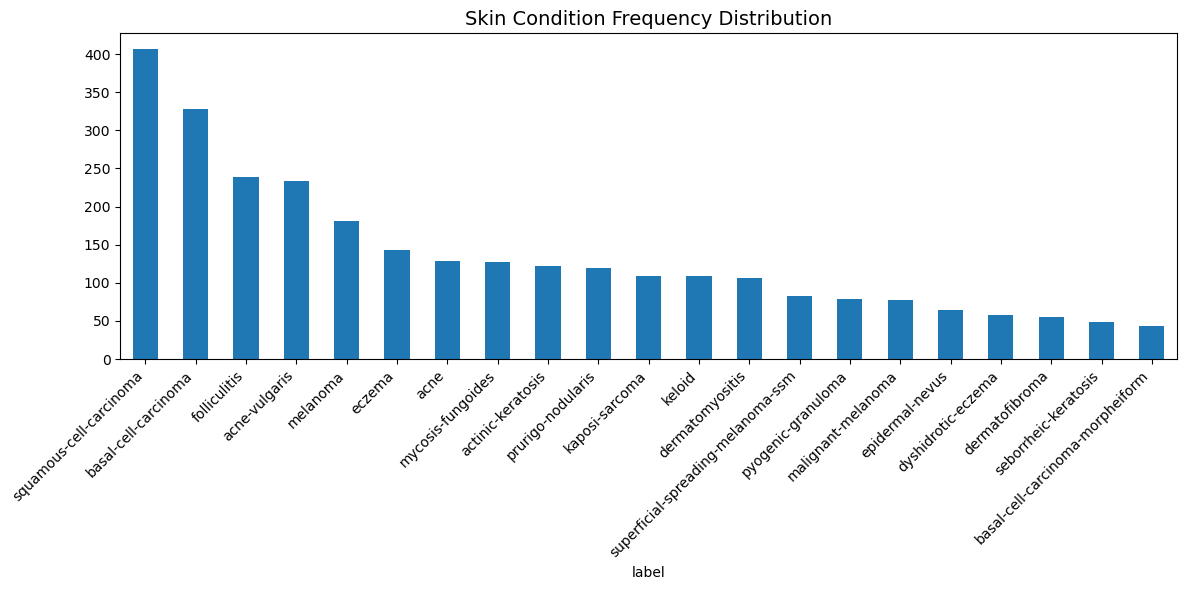

In [112]:
plt.figure(figsize=(12, 6))
df['label'].value_counts().plot.bar(rot=45, width=0.5)
plt.title("Skin Condition Frequency Distribution", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [114]:
df["qc"].value_counts()

qc
1 Diagnostic          76
5 Potentially          7
3 Wrongly labelled     4
2 Characteristic       2
4 Other                1
Name: count, dtype: int64

In [116]:
df["nine_partition_label"].value_counts()

nine_partition_label
inflammatory                    1017
malignant-epidermal              900
malignant-melanoma               342
benign-epidermal                 231
benign-dermal                    134
malignant-cutaneous-lymphoma     127
malignant-dermal                 109
Name: count, dtype: int64

In [118]:
df["three_partition_label"].value_counts()

three_partition_label
malignant         1478
non-neoplastic    1017
benign             365
Name: count, dtype: int64

In [120]:
# find all observations where qc = 3 (image is wrongly labelled) or qc = 5 (requires further testing to determine if image is misleading)
df.query("(qc == '3 Wrongly labelled' | qc == '5 Potentially')")

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,ddi_scale
840,a2df70f5967a76aa96825313635e18ef,3,2,folliculitis,inflammatory,non-neoplastic,3 Wrongly labelled,34
860,2e3b410b4c54081cac94ccfa3f9f8c8b,6,6,dermatomyositis,inflammatory,non-neoplastic,5 Potentially,56
961,424ca461d8e2d667d55f7af7c9fc035e,1,1,pyogenic-granuloma,benign-dermal,benign,5 Potentially,12
1405,fd14286c22b23ef54155d425c5967eed,2,2,acne,inflammatory,non-neoplastic,5 Potentially,12
1494,0adf95c81c80ef8b473022a203a0cb21,2,2,mycosis-fungoides,malignant-cutaneous-lymphoma,malignant,5 Potentially,12
1503,c5c075da4848a22e7b904957deb7c609,5,5,acne,inflammatory,non-neoplastic,3 Wrongly labelled,56
1560,b1881c3f24c95c6950b3d9e131406edb,1,1,prurigo-nodularis,benign-epidermal,benign,5 Potentially,12
1599,73ac23918c9537a8c792938b64f779e0,4,4,squamous-cell-carcinoma,malignant-epidermal,malignant,5 Potentially,34
1735,a7f4b5820d83edb709b22965f6b14135,2,2,folliculitis,inflammatory,non-neoplastic,3 Wrongly labelled,12
1994,75ec263a2f60119eb0e1f580a7aaec12,2,1,folliculitis,inflammatory,non-neoplastic,5 Potentially,12


## Data Preprocessing

In [122]:
#allows us to get images from directory into IDE
def get_image(index, df): # index must be from 0 to len(df) - 1
    num_rows = df.shape[0]
    if index < 0 or index >= num_rows:
        return "cannot get requested image"
    else:
        img_dir = df.loc[index, 'label']
        img_hash = df.loc[index, 'md5hash']

        img_path = os.path.join(os.getcwd(), "bttai-ajl-2025/train/train", img_dir, img_hash + ".jpg")
        print(img_path)

        # Check if the image exists in the specified directory
        if os.path.exists(img_path):
            # Open and display the image using PIL
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis('off')  # Turn off axis labels for a cleaner display

        else:
            return "Image not found at the specified path."

C:\Users\varsh\Documents\kaggle\bttai-ajl-2025/train/train\actinic-keratosis\29cec54fd4c616bcbc1b0eeb68d8f68b.jpg


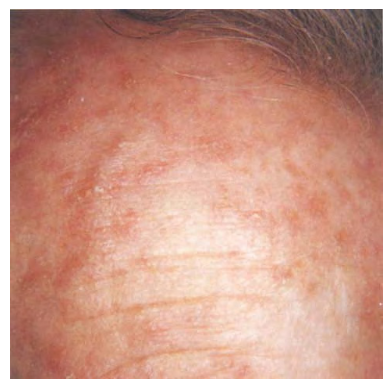

In [124]:
get_image(10, df) # this will display any index image in the original dataframe

In [126]:
#drop all values where qc is Wrongly Labelled
df = df[df['qc'] != '3 Wrongly labelled']

In [128]:
# One hot encode categorical variables (nine_partition_label, three_partition_label)
from sklearn.preprocessing import OneHotEncoder

to_encode = ["nine_partition_label", "three_partition_label"]
enc = OneHotEncoder(sparse_output=False)
df_enc = pd.DataFrame(enc.fit_transform(df[to_encode]))

df_enc.columns = enc.get_feature_names_out()
df.drop(columns=to_encode, inplace=True)

df1 = df_enc.reset_index()
df2 = df.reset_index()
test = pd.merge(df1, df2, left_on='index', right_on='index')
result = test.drop(columns=['index'])
df = result

# Define y as the one-hot encoded labels
y = df.filter(regex='^(nine_partition_label_|three_partition_label_)').values

# Verify shape of y
print(f"Shape of y: {y.shape}")

Shape of y: (2852, 10)


In [130]:
def load_images_into_df_with_augmentation(df, directory, image_size=(224, 224), augmentation_factor=3):
    num_rows = df.shape[0]
    
    # Initialize an empty list to store augmented image data
    augmented_images = []
    augmented_labels = []
    
    # Step 1: Calculate the class distribution (the number of images per class)
    class_counts = df['label'].value_counts()
    min_class_size = class_counts.min()  # smallest class size
    class_weights = class_counts / min_class_size  # how much to augment each class
    
    # Initialize the ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,  # Random rotations between -20 and +20 degrees
        width_shift_range=0.2,  # Random horizontal shift
        height_shift_range=0.2,  # Random vertical shift
        zoom_range=0.2,  # Random zoom
        horizontal_flip=True,  # Random horizontal flip
        fill_mode='nearest'  # Filling missing pixels after transformations
    )
    
    # Loop through the dataset and augment images
    for i in range(num_rows):
        img_dir = df.loc[i, 'label']
        img_hash = df.loc[i, 'md5hash']       
        img_path = os.path.join(os.getcwd(), directory , img_dir, img_hash + ".jpg")
        
        # Open the image using PIL
        img = Image.open(img_path)
        
        # Resize the image to the target size (no cropping)
        img_resized = img.resize(image_size)
        
        # Convert the image to a numpy array
        img_array = np.array(img_resized)
        
        # Apply MobileNet preprocessing (scaling pixel values)
        img_array = preprocess_input(img_array)
        
        # Add original image to the list
        augmented_images.append(img_array)
        augmented_labels.append(img_dir)

        
       
        for _ in range(augmentation_factor - 1):  # Create extra augmented examples for this image
            augmented_img = datagen.random_transform(img_array)
            augmented_images.append(augmented_img)
            augmented_labels.append(img_dir)
    
    # Convert the augmented images list into a numpy array
    augmented_images = np.array(augmented_images)
    
    return augmented_images, augmented_labels


In [6]:
def load_image_labels(label_list):
    labels = np.array(label_list, dtype='str')
    label_options = df['label'].unique()
    label_to_number = {label: idx for idx, label in enumerate(label_options)}
    numeric_labels = [label_to_number[label] for label in labels]
    
    return np.array(numeric_labels)

In [13]:
directory = "bttai-ajl-2025/train/train"  # Change this depending on working environment
image_data, image_labels = load_images_into_df_with_augmentation(df, directory)
image_labels = load_image_labels(image_labels)

## Modeling

### Convolutional Neural Network (CNN)

In [143]:
df = df[['md5hash','label']]
df.head()
# Directory containing images
image_dir = directory

# Get all subfolders (each subfolder represents a class)
class_names = sorted(os.listdir(image_dir))

# Create a mapping from class names to indices
class_name_to_index = {class_name: idx for idx, class_name in enumerate(class_names)}


# Function to load and preprocess an image
def load_and_process_image(image_path, label):
    # Read image file
    image = tf.io.read_file(image_path)
    # Decode the image
    image = tf.image.decode_jpeg(image, channels=3)  # Assumes images are in jpg format; adjust if necessary
    # Resize the image
    image = tf.image.resize(image, [224, 224])
    # Normalize the image
    image = image / 255.0
    return image, label

# Function to get image paths and labels
def get_image_paths_and_labels(image_dir):
    image_paths = []
    labels = []

    for subdir in os.listdir(image_dir):
        subfolder_path = os.path.join(image_dir, subdir)

        if os.path.isdir(subfolder_path):
            # Loop through all images in the subfolder
            for image_name in os.listdir(subfolder_path):
                if image_name.lower().endswith(('png', 'jpg', 'jpeg')):
                    # Build the full image path
                    image_path = os.path.join(subfolder_path, image_name)
                    # Assign the label (subfolder name) to the image
                    image_paths.append(image_path)
                    labels.append(class_name_to_index[subdir])  # Use index for class label

    return image_paths, labels

# Get all image paths and labels
image_paths, labels = get_image_paths_and_labels(image_dir)

# Create a TensorFlow Dataset from image paths and labels
image_paths = tf.constant(image_paths)
labels = tf.constant(labels)


# Create a tf.data Dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

# Map the loading and preprocessing function to the dataset
dataset = dataset.map(lambda x, y: load_and_process_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=1000)

# Split the dataset into train and test (e.g., 80% train, 20% test)
# Here, we will take the first 80% for training and the remaining 20% for testing

train_size = int(0.8 * len(image_paths))  # 80% for training
test_size = len(image_paths) - train_size  # 20% for testing

# Split the dataset into train and test
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

# Batch and prefetch the datasets for better performance
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [145]:
# Define the CNN model
def create_cnn_model(input_shape=(224, 224, 3), num_classes=10):
    model = models.Sequential()

    # First convolutional layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second convolutional layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Third convolutional layer
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output for the fully connected layers
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout layer to reduce overfitting

    # Output layer (Softmax for multi-class classification)
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',  # Suitable for integer labels
                  metrics=['accuracy'])

    return model

# Create the CNN model
model = create_cnn_model(input_shape=(224, 224, 3), num_classes=len(class_names))

# Print the model summary to check the architecture
model.summary()

C:\Users\varsh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 21)             │         2,709 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,171,669 (42.62 MB)

 Trainable params: 11,171,669 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

In [147]:
history = model.fit(train_dataset, epochs=30)
# Evaluate the model on the test dataset/
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc}")

Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 321ms/step - accuracy: 0.1613 - loss: 3.0033
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 418ms/step - accuracy: 0.1181 - loss: 2.9237
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 430ms/step - accuracy: 0.1487 - loss: 2.7636
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 492ms/step - accuracy: 0.1424 - loss: 2.7424
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 531ms/step - accuracy: 0.0893 - loss: 2.8612
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 526ms/step - accuracy: 0.1237 - loss: 2.9177
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 526ms/step - accuracy: 0.1370 - loss: 2.7898
Epoch 8/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 518ms/step - accuracy: 0.1500 - loss: 2.7430
Epoch 9/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 520ms/step - accuracy: 0.2229 - loss: 2.6249
Epoch 10/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 514ms/step - accuracy: 0.2023 - loss: 2.5978
Epoch 11/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 518ms/step - accuracy: 0.2140 - loss: 2.5933
Epoch 12/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 31

In [148]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9829 - loss: 0.1277
Test Accuracy: 0.9825174808502197


In [ ]:
# Path to the test image folder
image_folder = directory

# Load the trained model (replace 'best_model.h5' with your model's filename if needed)
 # Load the trained model

# Function to preprocess and predict on a single image
def preprocess_and_predict(img_path, model, target_size=(224, 224)):
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)  # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
    img_array = img_array / 255.0  # Normalize the image

    # Make prediction
    predictions = model.predict(img_array, verbose=0)

    # Get the predicted class index (if using softmax for multi-class classification)
    predicted_class_idx = np.argmax(predictions, axis=-1)[0]

    return predicted_class_idx, predictions
results = []
# Iterate over images in the test folder and make predictions
for subdir in os.listdir(image_folder):
    subfolder_path = os.path.join(image_folder, subdir)

    if os.path.isdir(subfolder_path):  # Ensure that we are looking at folders
        print(f"Processing images in {subdir} folder...")

        for img_name in os.listdir(subfolder_path):
            if img_name.lower().endswith(('png', 'jpg', 'jpeg')):  # Process image files only
                img_path = os.path.join(subfolder_path, img_name)

                # Preprocess image and get the prediction
                predicted_class_idx, predictions = preprocess_and_predict(img_path, model)
                        # Map the predicted class index to the class name
                predicted_class_name = class_names[predicted_class_idx]

        # Get the confidence (probability of the predicted class)
                confidence = np.max(predictions)
                
                # Append the result to the list
                results.append([img_name, predicted_class_name, confidence])
    # Convert results to a pandas DataFrame
df = pd.DataFrame(results, columns=['Image Name', 'Predicted Class', 'Confidence'])

# Store the predictions in a CSV file
csv_output_path = '/content/drive/MyDrive/BTTAI Kaggle AJL Team13/predictions.csv'  # Change the path if needed
df.to_csv(csv_output_path, index=False)

print(f"Predictions have been saved to {csv_output_path}")

In [ ]:
# Load the CSV file into a pandas DataFrame
csv_file_path = '/content/drive/MyDrive/BTTAI Kaggle AJL Team13/predictions.csv'
df = pd.read_csv(csv_file_path)

# Remove a column (e.g., 'Confidence'). Replace 'Confidence' with the name of the column you want to remove
df = df.drop(columns=['Confidence'])

# Display the DataFrame after removing the column
print("\nDataFrame after removing 'Confidence' column:")
df.rename(columns={'Image Name': 'md5hash', 'Predicted Class': 'label'}, inplace=True)
df['md5hash'] = df['md5hash'].str.slice(0, -4)

# Optionally, you can save the DataFrame back to a CSV if needed
df.to_csv('/content/drive/MyDrive/BTTAI Kaggle AJL Team13/submission_predictions.csv', index=False)

### MobileNet Transfer Learning

Epoch 1/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 220s 962ms/step - accuracy: 0.2956 - loss: 2.3998 - val_accuracy: 0.4755 - val_loss: 1.6335
Epoch 2/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 241s 859ms/step - accuracy: 0.7322 - loss: 0.9848 - val_accuracy: 0.6731 - val_loss: 1.0304
Epoch 3/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 182s 843ms/step - accuracy: 0.9093 - loss: 0.4861 - val_accuracy: 0.7290 - val_loss: 0.9094
Epoch 4/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 185s 766ms/step - accuracy: 0.9739 - loss: 0.2354 - val_accuracy: 0.7582 - val_loss: 0.7571
Epoch 5/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 202s 763ms/step - accuracy: 0.9921 - loss: 0.1155 - val_accuracy: 0.8508 - val_loss: 0.5247
Epoch 6/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 221s 852ms/step - accuracy: 0.9985 - loss: 0.0653 - val_accuracy: 0.8392 - val_loss: 0.5169
Epoch 7/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 185s 774ms/step - accuracy: 0.9995 - loss: 0.0412 - val_accuracy: 0.8683 - val_loss: 0.4394
Epoch 8/15
215/215 ━━━━━━━━━━━━━━━━━━━━ 201s 771ms/step - accuracy: 0.9986 -

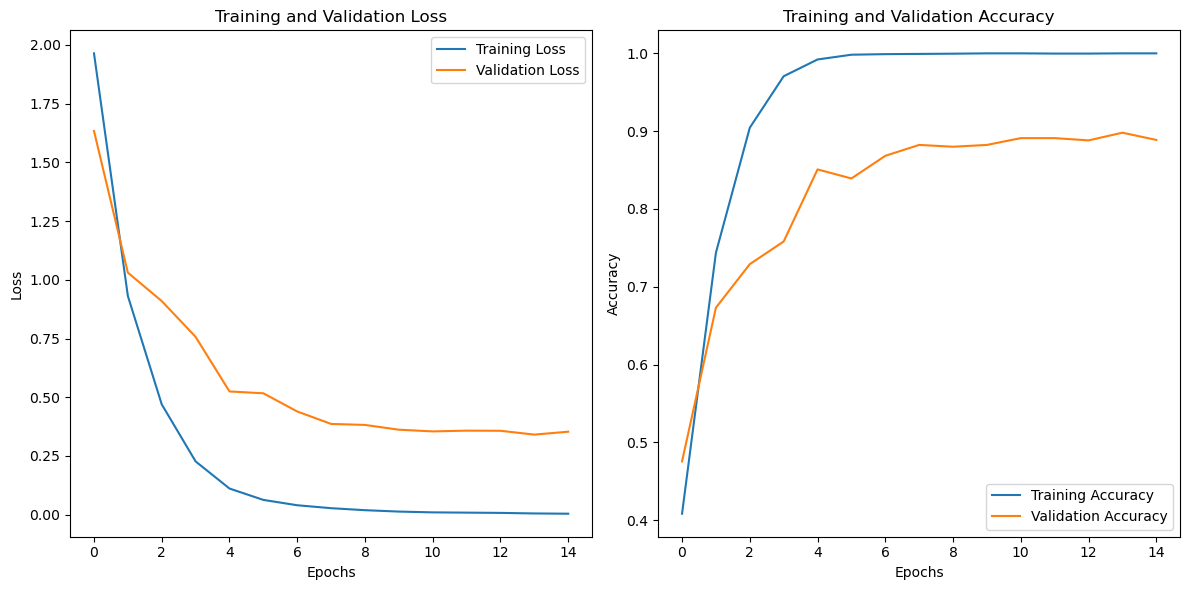

In [17]:
# Assuming image_data and image_labels are your dataframes
X_train, X_test, y_train, y_test = train_test_split(image_data, image_labels, test_size=0.2)

# One-hot encode the labels if they're integers (e.g., 0, 1, 2, ..., N-1)
num_classes = len(np.unique(y_train))  # Assuming you have a fixed number of classes
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Load the MobileNet base model without the top classification layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # For multi-class classification

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the first few layers and unfreeze the later ones
# For example, unfreeze the last 4 blocks of MobileNet
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze some layers from the end (e.g., last 20 blocks)
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile the model (recompile after unfreezing layers)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model (training only the unfrozen layers)
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step


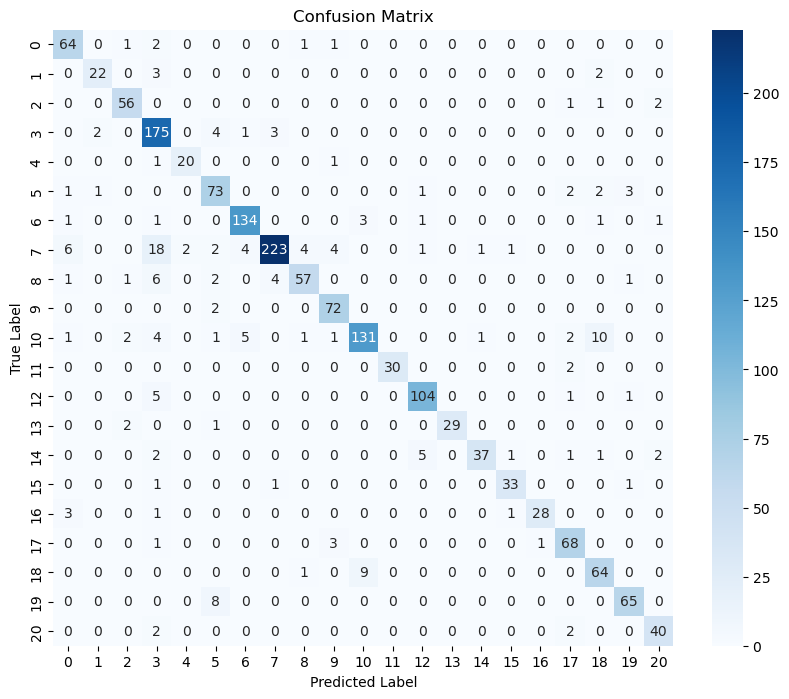

In [18]:
# Step 1: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 2: Convert one-hot encoded labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Step 3: Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Step 4: Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step


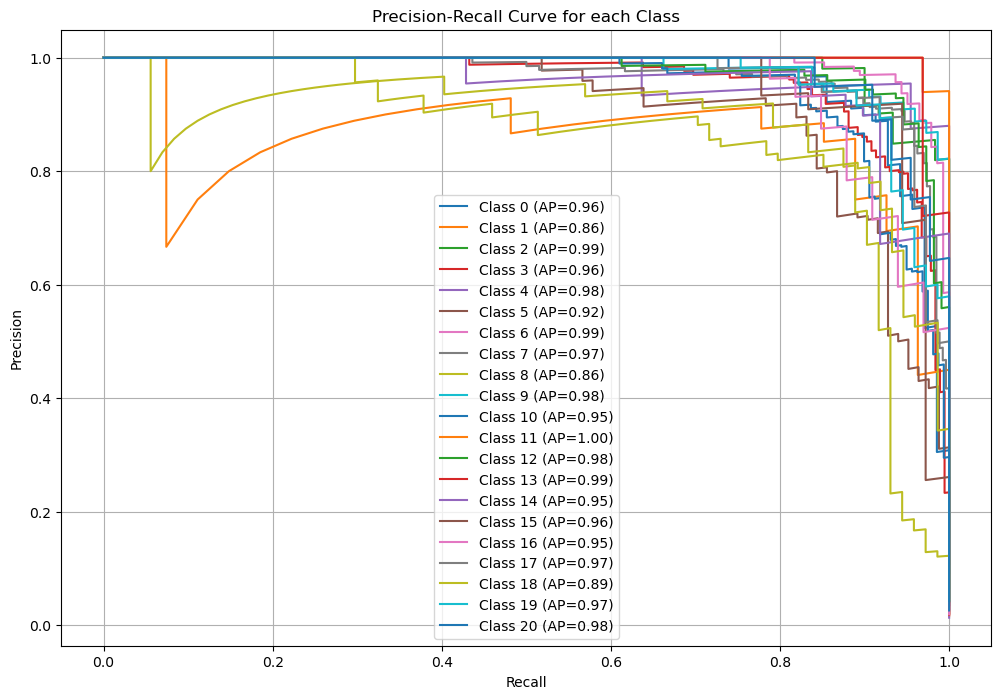

In [19]:
# Step 1: Get predicted probabilities for the test set
y_pred_prob = model.predict(X_test)

# Step 2: Plot precision-recall curve for each class
plt.figure(figsize=(12, 8))

for i in range(num_classes):
    # Compute precision-recall curve for each class
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP={average_precision_score(y_test[:, i], y_pred_prob[:, i]):.2f})')

# Step 3: Add labels and legend
plt.title('Precision-Recall Curve for each Class')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [67]:
def get_image(index, df):
    """Function to load an image from the dataset using md5hash and directory info from df."""
    num_rows = df.shape[0]
    if index < 0 or index >= num_rows:
        return None
    else:
        img_dir = df.loc[index, 'label']
        img_hash = df.loc[index, 'md5hash']
        img_path = os.path.join(os.getcwd(), "bttai-ajl-2025/train/train", img_dir, img_hash + ".jpg")
        
        if os.path.exists(img_path):
            # Open and return the image
            img = Image.open(img_path)
            return img
        else:
            return None

def preprocess_image(img):
    """Function to resize, convert to array, and preprocess the image."""
    img = img.resize((224, 224))  # Resize image to the input size expected by MobileNet
    img_array = img_to_array(img)  # Convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess the image as per MobileNet's requirements
    return img_array

# Create empty lists to store predictions and true labels
predictions = []
true_labels = []
scale = []
# Iterate through each row in the dataframe to make predictions on the original dataset
for index, row in df.iterrows():
    img = get_image(index, df)
    
    if img:
        # Preprocess the image
        img_array = preprocess_image(img)
        
        # Make prediction on the image
        pred = model.predict(img_array, verbose = 0)
        pred_class = np.argmax(pred, axis=1)[0]  # Get the predicted class
        
        # Append the prediction and the true label (Fitzpatrick scale)
        predictions.append(pred_class)
        true_labels.append(row['label'])  # Assuming you have this in the df
        scale.append(row['fitzpatrick_scale'])

# Now calculate accuracy per Fitzpatrick scale
df_results = pd.DataFrame({
    'true_labels': true_labels,
    'predictions': predictions,
    'fitzpatrick_scale' : scale
})


In [69]:
# Assuming df['label'].unique() gives the unique string labels
class_encodings = df['label'].unique()  # List of unique string labels

# Create a dictionary that maps string labels to numerical labels
label_to_num = {label: idx for idx, label in enumerate(class_encodings)}

# Map the true_labels to the numeric values based on the dictionary
df_results['true_labels'] = df_results['true_labels'].map(label_to_num)


In [71]:
df_results

,true_labels,predictions,fitzpatrick_scale
0,0,0,4
1,1,1,1
2,2,2,5
3,3,3,3
4,0,0,1
...,...,...,...
2855,6,6,2
2856,20,20,1
2857,18,18,1
2858,5,5,3


C:\Users\varsh\AppData\Local\Temp\ipykernel_19144\1813095815.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_per_scale = df_results.groupby('fitzpatrick_scale').apply(


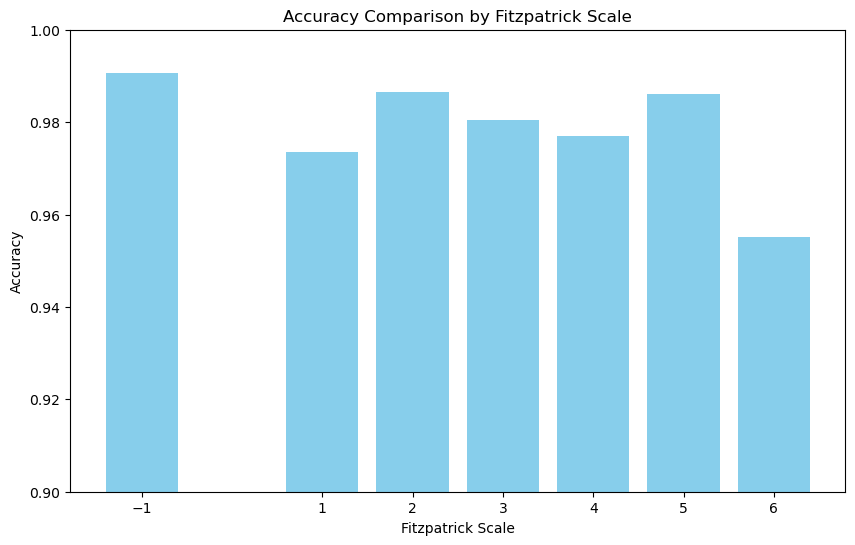

In [85]:
# Calculate accuracy per Fitzpatrick scale category
accuracy_per_scale = df_results.groupby('fitzpatrick_scale').apply(
    lambda group: (group['true_labels'] == group['predictions']).mean()
).reset_index(name='accuracy')

# Plotting the accuracy for each Fitzpatrick scale category
plt.figure(figsize=(10, 6))
plt.bar(accuracy_per_scale['fitzpatrick_scale'], accuracy_per_scale['accuracy'], color='skyblue')
plt.xlabel('Fitzpatrick Scale')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison by Fitzpatrick Scale')
plt.xticks(accuracy_per_scale['fitzpatrick_scale'])
plt.ylim(.9, 1)  # Accuracy range from 0 to 1
plt.show()


In [233]:

class_names = df['label'].unique()  


image_folder = os.path.join(os.getcwd(), "bttai-ajl-2025/test/test")  # Update with your folder path

# Initialize an empty list to store the results
results = []

# Loop through all images in the folder
for img_name in os.listdir(image_folder):
    if img_name.endswith('.jpg'):  # Ensure the file is a .jpg image
        # Extract the image hash from the filename (assuming it's formatted as img-hash.jpg)
        img_hash = img_name.split('.')[0]  # This gets the 'hash' part
        
        # Load and preprocess the image
        img_path = os.path.join(image_folder, img_name)
        img = image.load_img(img_path, target_size=(224, 224))  # Resize to 224x224 (MobileNet input size)
        img_array = image.img_to_array(img)  # Convert to numpy array
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        
        # Apply MobileNet-specific preprocessing
        img_array = preprocess_input(img_array)  # This applies the required preprocessing

        # Make prediction
        prediction = model.predict(img_array, verbose=0)
        
        # Get the predicted class index (the highest probability)
        predicted_class_idx = np.argmax(prediction, axis=1)[0]
        
        # Convert the predicted class index to the actual class name
        predicted_class_name = class_names[predicted_class_idx]
        
        # Append the result (image hash and predicted class name)
        results.append([img_hash, predicted_class_name])

# Create a pandas DataFrame from the results
df2 = pd.DataFrame(results, columns=['md5hash', 'prediction'])

# Save the DataFrame to a CSV file
df2.to_csv('submission_13.csv', index=False)

print("Predictions saved to submission_13.csv")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 